In [12]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### Get Land Use data

In [13]:
parcel_points_gdf = gpd.read_file('./data/NYS_Tax_Parcels_Public_Points_2022.geojson')

In [14]:
# get shortage_tracts_gdf and compute additional columns
shortage_tracts_gdf = gpd.read_file('./data/shortage_tracts_gdf_1pcp220.geojson')
shortage_tracts_gdf['unserved medicaid enrollees per km2'] = (shortage_tracts_gdf['unserved_medicaid'] / shortage_tracts_gdf['ALAND'] * 1000000).round(1)
shortage_tracts_gdf['unserved commercial insurance enrollees per km2'] = (shortage_tracts_gdf['unserved_commercial'] / shortage_tracts_gdf['ALAND'] * 1000000).round(1)
shortage_tracts_gdf['insured population per km2'] = ((shortage_tracts_gdf['medicaid'] + shortage_tracts_gdf['commercial']) / shortage_tracts_gdf['ALAND'] * 1000000).round(1)

columns_to_keep = ['COUNTYFP', 'GEOID', 'geometry', 'insured population per km2', 'unserved medicaid enrollees per km2', 'unserved commercial insurance enrollees per km2', 'medicaid', 'commercial']
shortage_tracts_gdf = shortage_tracts_gdf[columns_to_keep]
shortage_tracts_gdf['GEOID'] = shortage_tracts_gdf['GEOID'].astype('string')
print(shortage_tracts_gdf.shape)
print(shortage_tracts_gdf.columns)

(3533, 8)
Index(['COUNTYFP', 'GEOID', 'geometry', 'insured population per km2',
       'unserved medicaid enrollees per km2',
       'unserved commercial insurance enrollees per km2', 'medicaid',
       'commercial'],
      dtype='object')


In [15]:
# Perform the spatial join
joined_gdf = gpd.sjoin(parcel_points_gdf, shortage_tracts_gdf, how="inner", predicate='within')
print(joined_gdf.columns)

# Calculate land use data while processing spatial join
residential_area_sum_sqft = joined_gdf.groupby('GEOID')['SQFT_LIVING'].sum().reset_index(name='residential_area_sum_sqft')
commercial_area_sum_sqft = joined_gdf.groupby('GEOID')['GFA'].sum().reset_index(name='commercial_area_sum_sqft')
agriculture_ratio = (joined_gdf.groupby('GEOID')['agriculture'].sum() / joined_gdf.groupby('GEOID')['agriculture'].count()).reset_index(name='agriculture_ratio').round(2)
residential_ratio = (joined_gdf.groupby('GEOID')['residential'].sum() / joined_gdf.groupby('GEOID')['residential'].count()).reset_index(name='residential_ratio').round(2)
vacant_ratio = (joined_gdf.groupby('GEOID')['vacant'].sum() / joined_gdf.groupby('GEOID')['vacant'].count()).reset_index(name='vacant_ratio').round(2)
commercial_ratio = (joined_gdf.groupby('GEOID')['commercial_left'].sum() / joined_gdf.groupby('GEOID')['commercial_left'].count()).reset_index(name='commercial_ratio').round(2)
industrial_ratio = (joined_gdf.groupby('GEOID')['industrial'].sum() / joined_gdf.groupby('GEOID')['industrial'].count()).reset_index(name='industrial_ratio').round(2)
avg_land_price_per_sqft = joined_gdf.groupby('GEOID')['land_price_per_sqft(dollars)'].mean().reset_index(name='avg_land_price_per_sqft').round(2)

# Merge the average land price back into merged_gdf
shortage_tracts_gdf = shortage_tracts_gdf.merge(residential_area_sum_sqft, left_on='GEOID', right_on='GEOID')
shortage_tracts_gdf = shortage_tracts_gdf.merge(commercial_area_sum_sqft, left_on='GEOID', right_on='GEOID')
shortage_tracts_gdf = shortage_tracts_gdf.merge(agriculture_ratio, left_on='GEOID', right_on='GEOID')
shortage_tracts_gdf = shortage_tracts_gdf.merge(residential_ratio, left_on='GEOID', right_on='GEOID')
shortage_tracts_gdf = shortage_tracts_gdf.merge(vacant_ratio, left_on='GEOID', right_on='GEOID')
shortage_tracts_gdf = shortage_tracts_gdf.merge(commercial_ratio, left_on='GEOID', right_on='GEOID')
shortage_tracts_gdf = shortage_tracts_gdf.merge(industrial_ratio, left_on='GEOID', right_on='GEOID')
shortage_tracts_gdf = shortage_tracts_gdf.merge(avg_land_price_per_sqft, left_on='GEOID', right_on='GEOID')
shortage_tracts_gdf = shortage_tracts_gdf.dropna()

Index(['SQFT_LIVING', 'GFA', 'land_price_per_sqft(dollars)', 'agriculture',
       'residential', 'vacant', 'commercial_left', 'industrial', 'geometry',
       'index_right', 'COUNTYFP', 'GEOID', 'insured population per km2',
       'unserved medicaid enrollees per km2',
       'unserved commercial insurance enrollees per km2', 'medicaid',
       'commercial_right'],
      dtype='object')


In [16]:
shortage_tracts_gdf["residential_area_per_sqft"] = (shortage_tracts_gdf["residential_area_sum_sqft"] / shortage_tracts_gdf.geometry.area).round(2)
shortage_tracts_gdf["commercial_area_per_sqft"] = (shortage_tracts_gdf["commercial_area_sum_sqft"] / shortage_tracts_gdf.geometry.area).round(2)
# 1km2 = 10763910.4ft2
shortage_tracts_gdf["medicaid enrollees per km2"] = (shortage_tracts_gdf["medicaid"] / shortage_tracts_gdf.geometry.area * 10763910.4).round(2)
shortage_tracts_gdf["commercial enrollees per km2"] = (shortage_tracts_gdf["commercial"] / shortage_tracts_gdf.geometry.area * 10763910.4).round(2)

print(shortage_tracts_gdf.shape)
print(shortage_tracts_gdf.columns)

(3533, 20)
Index(['COUNTYFP', 'GEOID', 'geometry', 'insured population per km2',
       'unserved medicaid enrollees per km2',
       'unserved commercial insurance enrollees per km2', 'medicaid',
       'commercial', 'residential_area_sum_sqft', 'commercial_area_sum_sqft',
       'agriculture_ratio', 'residential_ratio', 'vacant_ratio',
       'commercial_ratio', 'industrial_ratio', 'avg_land_price_per_sqft',
       'residential_area_per_sqft', 'commercial_area_per_sqft',
       'medicaid enrollees per km2', 'commercial enrollees per km2'],
      dtype='object')


### Get Mode of Transportation data

In [17]:
transportation_df = pd.read_csv('./data/Means of Transportation to Work by Vehicles Available (ACSDT5Y2022.B08141)/ACSDT5Y2022.B08141-Data.csv')
transportation_df = transportation_df.iloc[1:, :]

columns_to_keep = ['GEO_ID', 'B08141_006E', 'B08141_011E', 'B08141_016E', 'B08141_021E', 'B08141_026E', 'B08141_031E']
transportation_df = transportation_df[columns_to_keep]
transportation_df.rename(columns={'B08141_006E': 'drove alone', 'B08141_011E': 'carpooled', 'B08141_016E': 'public transit', 'B08141_021E': 'walked', 'B08141_026E': 'taxicab, motorcycle, bicycle, or other means', 'B08141_031E': 'worked from home'}, inplace=True)
transportation_df['GEO_ID'] = transportation_df['GEO_ID'].str.slice(-11)

# Ensure numerica datatype 
non_numeric_cols = transportation_df.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_cols:
    if col == 'GEO_ID':
        continue
    transportation_df[col] = pd.to_numeric(transportation_df[col], errors='coerce')

print(transportation_df.shape)
print(transportation_df.columns)
print(transportation_df.dtypes)

(5411, 7)
Index(['GEO_ID', 'drove alone', 'carpooled', 'public transit', 'walked',
       'taxicab, motorcycle, bicycle, or other means', 'worked from home'],
      dtype='object')
GEO_ID                                          object
drove alone                                      int64
carpooled                                        int64
public transit                                   int64
walked                                           int64
taxicab, motorcycle, bicycle, or other means     int64
worked from home                                 int64
dtype: object


In [18]:
sum = transportation_df['drove alone'] + transportation_df['carpooled'] + transportation_df['public transit'] + transportation_df['walked'] + transportation_df['taxicab, motorcycle, bicycle, or other means'] + transportation_df['worked from home']
transportation_df['% workers drove alone'] = (transportation_df['drove alone'] / sum).round(2)
transportation_df['% workers public transit'] = (transportation_df['public transit'] / sum).round(2)
transportation_df['% workers walked'] = (transportation_df['walked'] / sum).round(2)
transportation_df['% workers worked from home'] = (transportation_df['worked from home'] / sum).round(2)
transportation_df['% workers carpooled'] = (transportation_df['carpooled'] / sum).round(2)

transportation_df = transportation_df[['GEO_ID', '% workers drove alone', '% workers carpooled', '% workers public transit', '% workers walked', '% workers worked from home']]
print(transportation_df.sample(10))

           GEO_ID  % workers drove alone  % workers carpooled  \
1565  36047039400                   0.43                 0.07   
4465  36091062410                   0.80                 0.05   
1635  36047047200                   0.27                 0.01   
1195  36045061200                   0.69                 0.12   
2609  36061003400                   0.00                 0.01   
856   36029005300                   0.73                 0.04   
4607  36103111508                   0.64                 0.10   
1555  36047038300                   0.16                 0.01   
5042  36111951400                   0.79                 0.10   
628   36015011101                   0.89                 0.05   

      % workers public transit  % workers walked  % workers worked from home  
1565                      0.17              0.30                        0.02  
4465                      0.00              0.03                        0.11  
1635                      0.15              0.3

### Merge Land Use & Mode of Transportation data

In [20]:
merged_gdf = shortage_tracts_gdf.merge(transportation_df, how='left', left_on='GEOID', right_on='GEO_ID')
merged_gdf = merged_gdf[[
    'GEOID', 'geometry', 'insured population per km2',
    'unserved medicaid enrollees per km2', 'unserved commercial insurance enrollees per km2', 
    'medicaid enrollees per km2', 'commercial enrollees per km2', 'agriculture_ratio', 'residential_ratio', 
    'vacant_ratio', 'commercial_ratio', 'industrial_ratio', 'avg_land_price_per_sqft',
    'residential_area_per_sqft', 'commercial_area_per_sqft', '% workers drove alone', 
    '% workers carpooled', '% workers public transit', '% workers walked', '% workers worked from home'
]]

# print(merged_gdf.columns)
# print(merged_gdf.shape)
print(shortage_tracts_gdf.columns)

Index(['COUNTYFP', 'GEOID', 'geometry', 'insured population per km2',
       'unserved medicaid enrollees per km2',
       'unserved commercial insurance enrollees per km2', 'medicaid',
       'commercial', 'residential_area_sum_sqft', 'commercial_area_sum_sqft',
       'agriculture_ratio', 'residential_ratio', 'vacant_ratio',
       'commercial_ratio', 'industrial_ratio', 'avg_land_price_per_sqft',
       'residential_area_per_sqft', 'commercial_area_per_sqft',
       'medicaid enrollees per km2', 'commercial enrollees per km2'],
      dtype='object')


### Get Health and profitability data
### Merge all features for clustering analysis

In [29]:
tracts_vulnerability_gdf = gpd.read_file('./data/shortage_tracts_with_vulnerability.geojson')
tracts_profitability_gdf = gpd.read_file('./data/shortage_tracts_with_profitability.geojson')

In [50]:
print(type(merged_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [40]:
# merge all features
tracts_with_features_gdf = merged_gdf.merge(tracts_vulnerability_gdf, how='left', left_on='GEOID', right_on='GEOID')
tracts_with_features_gdf = tracts_with_features_gdf.dropna()
tracts_with_features_gdf = tracts_with_features_gdf.merge(tracts_profitability_gdf, how='left', left_on='GEOID', right_on='GEOID')
tracts_with_features_gdf = tracts_with_features_gdf.dropna()
print(tracts_with_features_gdf.shape)

tracts_with_features_gdf = tracts_with_features_gdf[[
    'GEOID', 'geometry', 'medicaid enrollees per km2', 'commercial enrollees per km2', 'insured population per km2_x',
    'unserved medicaid enrollees per km2', 'unserved commercial insurance enrollees per km2_x', 
    'avg_land_price_per_sqft_x', 'agriculture_ratio', 'residential_ratio', 'vacant_ratio', 'commercial_ratio', 'industrial_ratio',
    'residential_area_per_sqft', 'commercial_area_per_sqft', '% workers drove alone', '% workers carpooled',
    '% workers public transit', '% workers walked', '% workers worked from home', 
    'No leisure-time physical activity', 'Binge drinking', 'Sleeping less than 7 hours', 'Current smoking',
    'Cholesterol screening', 'Current lack of health insurance', 'Taking medicine for high blood pressure control',
    'Visits to dentist or dental clinic', 'Visits to doctor for routine checkup within the past',
    'Physical health not good for >=14 days', 'Mental health not good for >=14 days', 'Fair or poor self-rated health status', 
    'Median household income', 'Median household disposable income', 'Median monthly housing cost'
]]
tracts_with_features_gdf["unserved population per km2"] = tracts_with_features_gdf["unserved medicaid enrollees per km2"] + tracts_with_features_gdf['unserved commercial insurance enrollees per km2_x']

(984, 42)


In [48]:
print(type(tracts_with_features_gdf))

<class 'pandas.core.frame.DataFrame'>


In [45]:
# Dictionary mapping old column names to new names
rename_dict = {
    'medicaid enrollees per km2': 'medicaid enrollees / km2',
    'commercial enrollees per km2': 'commercial enrollees / km2',
    'insured population per km2_x': 'insured population / km2',
    'unserved medicaid enrollees per km2': 'unserved medicaid enrollees / km2',
    'unserved commercial insurance enrollees per km2_x': 'unserved commercial enrollees / km2',
    'unserved population per km2': 'unserved population / km2',
    'avg_land_price_per_sqft_x': 'average land price / ft2',
    'agriculture_ratio': 'agricultural land percent',
    'residential_ratio': 'residential district percent',
    'vacant_ratio': 'vacant land percent',
    'commercial_ratio': 'commercial district percent',
    'industrial_ratio': 'industrial district percent',
    'residential_area_per_sqft': 'residential area / ft2',
    'commercial_area_per_sqft': 'commercial area / ft2',
    '% workers drove alone': 'drove alone percent',
    '% workers carpooled': 'carpooled percent',
    '% workers public transit': 'public transit percent',
    '% workers walked': 'walked percent',
    '% workers worked from home': 'worked from home percent',
    'No leisure-time physical activity': 'no leisure-time physical activity',
    'Binge drinking': 'binge drinking',
    'Sleeping less than 7 hours': 'sleeping less than 7 hours',
    'Current smoking': 'current smoking',
    'Cholesterol screening': 'cholesterol screening',
    'Current lack of health insurance': 'current lack of health insurance',
    'Taking medicine for high blood pressure control': 'taking medicine for high blood pressure',
    'Visits to dentist or dental clinic': 'visits to dentist or dental clinic',
    'Visits to doctor for routine checkup within the past': 'visits to doctor for routine checkup',
    'Physical health not good for >=14 days': 'physical health not good for >=14 days',
    'Mental health not good for >=14 days': 'mental health not good for >=14 days',
    'Fair or poor self-rated health status': 'fair or poor self-rated health status',
    'Median household income': 'median household income',
    'Median household disposable income': 'median household disposable income',
    'Median monthly housing cost': 'median monthly housing cost'
}
 
# Rename the columns
tracts_with_features_gdf = tracts_with_features_gdf.rename(columns=rename_dict)

# Print the updated column names to verify changes
print(tracts_with_features_gdf.columns)

Index(['GEOID', 'geometry', 'medicaid enrollees / km2',
       'commercial enrollees / km2', 'insured population / km2',
       'unserved medicaid enrollees / km2',
       'unserved commercial enrollees / km2', 'average land price / ft2',
       'agricultural land percent', 'residential district percent',
       'vacant land percent', 'commercial district percent',
       'industrial district percent', 'residential area / ft2',
       'commercial area / ft2', 'drove alone percent', 'carpooled percent',
       'public transit percent', 'walked percent', 'worked from home percent',
       'no leisure-time physical activity', 'binge drinking',
       'sleeping less than 7 hours', 'current smoking',
       'cholesterol screening', 'current lack of health insurance',
       'taking medicine for high blood pressure',
       'visits to dentist or dental clinic',
       'visits to doctor for routine checkup',
       'physical health not good for >=14 days',
       'mental health not good for >

In [57]:
tracts_with_features_gdf = gpd.GeoDataFrame(tracts_with_features_gdf, geometry='geometry')
tracts_with_features_gdf = tracts_with_features_gdf.to_crs("EPSG:4326")
print(tracts_with_features_gdf.crs)

EPSG:4326


In [83]:
# Simplify geometries
tolerance = 0.0001  # Adjust this based on your specific requirements and units of your CRS
tracts_with_features_gdf['geometry'] = tracts_with_features_gdf['geometry'].simplify(tolerance, preserve_topology=True)

In [84]:
tracts_with_features_gdf.to_file('shortage_tracts_with_features.geojson', driver='GeoJSON')

In [61]:
# Get list of {min:x, max:y, name:z} object
columns = ['medicaid enrollees / km2',
       'commercial enrollees / km2', 'insured population / km2',
       'unserved medicaid enrollees / km2',
       'unserved commercial enrollees / km2', 'average land price / ft2',
       'agricultural land percent', 'residential district percent',
       'vacant land percent', 'commercial district percent',
       'industrial district percent', 'residential area / ft2',
       'commercial area / ft2', 'drove alone percent', 'carpooled percent',
       'public transit percent', 'walked percent', 'worked from home percent',
       'no leisure-time physical activity', 'binge drinking',
       'sleeping less than 7 hours', 'current smoking',
       'cholesterol screening', 'current lack of health insurance',
       'taking medicine for high blood pressure',
       'visits to dentist or dental clinic',
       'visits to doctor for routine checkup',
       'physical health not good for >=14 days',
       'mental health not good for >=14 days',
       'fair or poor self-rated health status', 'median household income',
       'median household disposable income', 'median monthly housing cost',
       'unserved population / km2']

stats_list = [
    {
        'name': col,
        'min': tracts_with_features_gdf[col].min(),
        'max': tracts_with_features_gdf[col].max()
    } 
    for col in columns
]

# Display the resulting list of dictionaries
print(stats_list)

import json
json_data = json.dumps(stats_list)

# Set the filename where you want to store the JSON data
filename = 'shortage_tracts_with_features_min_max.json'

# Write the JSON string to a file
with open(filename, 'w') as file:
    file.write(json_data)

print(f"JSON data has been written to {filename}")

[{'name': 'medicaid enrollees / km2', 'min': 1.09, 'max': 55472.48}, {'name': 'commercial enrollees / km2', 'min': 6.12, 'max': 42294.7}, {'name': 'insured population / km2', 'min': 10.0, 'max': 76410.9}, {'name': 'unserved medicaid enrollees / km2', 'min': 0.0, 'max': 45610.7}, {'name': 'unserved commercial enrollees / km2', 'min': 0.0, 'max': 12665.9}, {'name': 'average land price / ft2', 'min': 0.0, 'max': 34.29}, {'name': 'agricultural land percent', 'min': 0.0, 'max': 0.25}, {'name': 'residential district percent', 'min': 0.0, 'max': 1.0}, {'name': 'vacant land percent', 'min': 0.0, 'max': 0.53}, {'name': 'commercial district percent', 'min': 0.0, 'max': 0.57}, {'name': 'industrial district percent', 'min': 0.0, 'max': 0.18}, {'name': 'residential area / ft2', 'min': 0.0, 'max': 2.64}, {'name': 'commercial area / ft2', 'min': 0.0, 'max': 1.12}, {'name': 'drove alone percent', 'min': 0.01, 'max': 0.98}, {'name': 'carpooled percent', 'min': 0.0, 'max': 0.3}, {'name': 'public transit

In [79]:
tracts_gdf = gpd.read_file('./data/tracts.geojson')

In [80]:
print(tracts_gdf.shape)

(3670, 1)


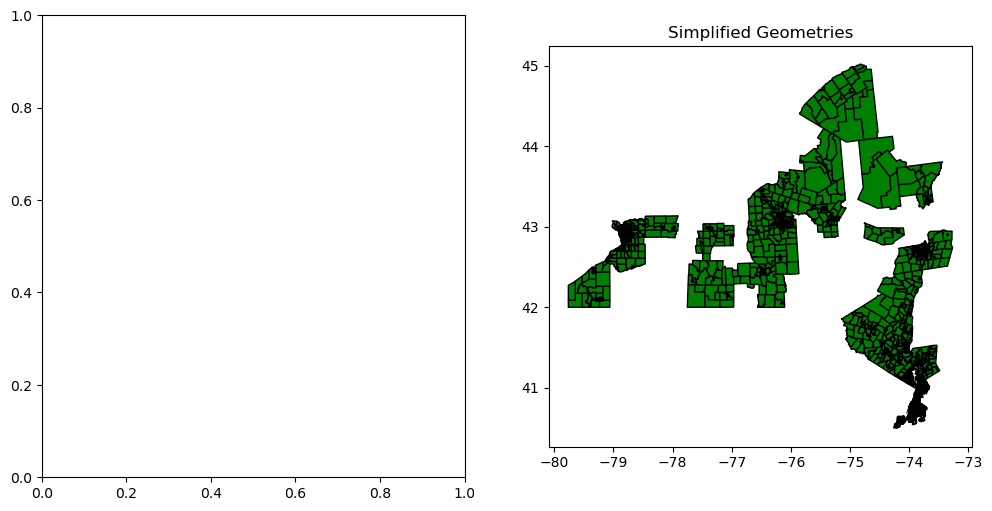

In [81]:
# Simplify geometries
tolerance = 0.0001  # Adjust this based on your specific requirements and units of your CRS
tracts_gdf['geometry'] = tracts_gdf['geometry'].simplify(tolerance, preserve_topology=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot simplified GeoDataFrame
tracts_gdf.plot(ax=ax[1], color='green', edgecolor='k')
ax[1].set_title('Simplified Geometries')

plt.show()

In [82]:
tracts_gdf.to_file('tracts.geojson', driver='GeoJSON')